# Part 6.2 - Analysis Topic Model of Train Set
---
### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import filter_topics, plot_topics
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
from wordcloud import WordCloud
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline

**For computing resource limitation, we did not train the full dataset, but trained a random sampling dataset (train set). In this part, we will use the topic modeling result from part 6.1 to analyze the train set making a general analysis.** 

**To evaluate and compare the distribution of topics, we use two basic metrics, in practice we use both to find interesting topics:**
1. The dominant topic counts. 

    Every document has a dominant topic represent the most portion of its contents. By summing the number of each dominant topic in a range of time, we see the variety and trend of each topic over time. It is easy to understand and fit for scatter plot, but in this way it ignores  non-dominant topics.

1. The average weight of topics over time.

    This metric is the average weight of a topic through all documents in a range of time, it avoid the issue above, reflect the topic variety and trend over time. However, it might give a frequent/normal topic (which has a small weight in each document) a high weight because the topic appears in large number of documents, when sum all weights of each topic and divid by total weight of all topics, this normal topic may get a high weight.
    

**To visualize the topics, we use all or part of below plots:**

1. word cloud to display topic words.

1. Scatter plot to dispaly the dominant tpics distribution over time.

1. Bar chart to display the dominant topics count over time.

1. Point plot to display the average topic weight over time.

## 1 Load dataframes

**Load the processed dataframes:**
* `topicKeys.txt`: topic words list
* `domTopic.csv`: document dominant topics dataframe
* `avgWeight.csv`: average topic weight dataframe

**Topics List:**

In [2]:
path = r'../models/train/topicKeys.txt'

df_topics = (pd.read_table(path, 
                           header=None, 
                           index_col=None, 
                           names = ['topic_', 'weight_', 'keywords_'],
                           encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape

In [3]:
print('Shape of dataframe:', topics_shape)
df_topics.head()

Shape of dataframe: (200, 3)


topic_  weight_  \
0       0  0.00194   
1       1  0.00774   
2       2  0.00689   
3       3  0.00764   
4       4  0.00998   

                                                                                                                 keywords_  
0  theatre tonight exhibition universal approved adults censor recommended comedy tomorrow night plans dance george dan...  
1  day people procession mayor city crowd town large governor reception band morning great afternoon excellency visit p...  
2  election electors candidate candidates vote poll district votes elections returning elected officer council seat ele...  
3  oamaru aro thames dunedin north otago street waitaki john zealand town timaru kurow fleming good tyne sumpter hold g...  
4  christchurch timaru ashburton street canterbury akaroa lyttelton east road south john colombo bay temuka thomas burn...

**Docmument - dominant topics dataframe:**

In [4]:
path = r'../models/train/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords_'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

# short keywords for easy plot
df_domtopic['keywords'] = df_domtopic['keywords_'].str.slice(0,60)+'...'
df_domtopic.drop("keywords_", axis=1, inplace=True)

In [5]:
print('Shape of dataframe:', df_domtopic.shape)
df_domtopic.sample(5)

Shape of dataframe: (1814086, 6)


id    region  year  topic    weight  \
0  1854215  Auckland  1862     92  0.342072   
1  1854221  Auckland  1862    173  0.915641   
2  1854224  Auckland  1862    173  0.876392   
3  1854233  Auckland  1863      8  0.409643   
4  1854245  Auckland  1863     14  0.301554   

                                                          keywords  
0  captain vessel ship steamer boat sea board crew port water p...  
1  love life heart day thy god world man eyes thou light long n...  
2  love life heart day thy god world man eyes thou light long n...  
3  business public begs orders stock notice attention inform pr...  
4  freight apply company passage new_zealand passengers steam l...

**Average topic weight dataframe:**

In [6]:
path = r'../models/train/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df_avgweight = pd.read_csv(path, 
                           header=None, 
                           index_col=None, 
                           names = columns,
                           dtype={0:'str'},
                           encoding='utf8')

# melt for plot
df_avgweight = pd.melt(df_avgweight,
                       id_vars='year',
                       value_vars=list(df_avgweight.columns[1:]),
                       var_name='topic',
                       value_name='weight')
# change data type
df_avgweight.topic = df_avgweight.topic.astype(int)

# join
df_avgweight = (df_avgweight
                .merge(df_topics, left_on='topic', right_on='topic_')
                .drop('topic_', axis=1)
                .drop('weight_', axis=1)
                .sort_values(by=['year', 'topic'])
                .reset_index(drop=True))

# short keywords for easy plot
df_avgweight['keywords'] = df_avgweight['keywords_'].str.slice(0,60)+'...'
df_avgweight.drop("keywords_", axis=1, inplace=True)

df_topics.columns = ['topic', 'weight', 'keywords']

In [7]:
print('Shape of dataframe:', df_avgweight.shape)
df_avgweight.sample(5)

Shape of dataframe: (20800, 4)


year  topic    weight  \
0  1839      0  0.000006   
1  1839      1  0.000022   
2  1839      2  0.000020   
3  1839      3  0.000022   
4  1839      4  0.000029   

                                                          keywords  
0  theatre tonight exhibition universal approved adults censor ...  
1  day people procession mayor city crowd town large governor r...  
2  election electors candidate candidates vote poll district vo...  
3  oamaru aro thames dunedin north otago street waitaki john ze...  
4  christchurch timaru ashburton street canterbury akaroa lytte...

## 2 The Most Distinct Documents

**First of all, check the document with the highest weight topic through all documents, which means the document contains the fewest topics, easy to check the topic by eyes. Most this kind of documents are oversimplified, but it is a simple way to check topics. Here we print the top one of them.**

In [8]:
df_domtopic.sort_values(by='weight', ascending=False).head(3)

id      region  year  topic    weight  \
298420   6026304  West Coast  1873     60  0.998763   
281191   5759933  West Coast  1872     60  0.998760   
973509  16981879  Wellington  1931    188  0.998671   

                                                               keywords  
298420  milk dairy butter factory foot cheese cubic cwt cream cent c...  
281191  milk dairy butter factory foot cheese cubic cwt cream cent c...  
973509  auckland wellington left due london lyttelton october septem...

In [9]:
id_ = df_domtopic.sort_values(by='weight', ascending=False).iloc[0]['id']
id_

6026304

In [10]:
%%bash -s $id_

echo 'Print 1500 characters of document id: '$1
grep -nw ../data/dataset/sample/train/train.csv -e $1 | cut -c1-2000

Print 1500 characters of document id: 6026304
298421:6026304	THE TARIFF.	"THE TARIFF.Ale, porter, beer of all sorts, cider and perry in bottle, Is 3d per gallon Ale, porter, beer of all sorts, cider and perry iv bulk, Is per gallon Almonds, in shell, Id per lb Almonds, shelled, 3d per lb Aluiun, 3s per cubic foot Apparel, not otherwise described, 5s per cubic foot Apples, dried, Id per lb Apothecary's wares, not otherwise described, 3s Der cubin foot Arms, firearms, 5s each Axles, axle arms and boxes, 2s per cwt Arrowroot, in bulk, £d per lb Arrowroot, in bottles, jars, or tins, 2s 6d pei cubic foot Arsenic, 4s per cwt Acetic acid, 3s per cubic foot American cloth, 5s per do Bacon and hams, Id per lb Bagging, bags, sacks, and woolpacks (empty Is 6d per cubic foot Baskets and wickerware, 6d per cubic foot Baking-powder, Is per cubic foot Bedford cord trousers, 3s do Beef, salted, 2s per CAvt Beer engines and fittings, 4s per cubic foot Bellows, Is per cubic foot Bezique cards, as playin

## 3 General Distribution of Topics

### 3.1 Word Cloud

**Since MALLET outputs topic keywords without weight of each keywords, so we will add sequential weight (like arithmetic progression) for each keywords, which means the weight of each keywords is not accurate, but for word cloud it is acceptable. Below plot shows the first 20 topics in topics list.**

In [11]:
df_plt = df_topics.copy(deep=True)

def addWeight(keywords):
    k = keywords.split()
    s = sum(range(len(k)+1))
    v = [i / s for i in range(len(k), 0, -1)]
    return dict(zip(k, v))

df_plt['cloudwords'] = df_plt['keywords'].map(addWeight)

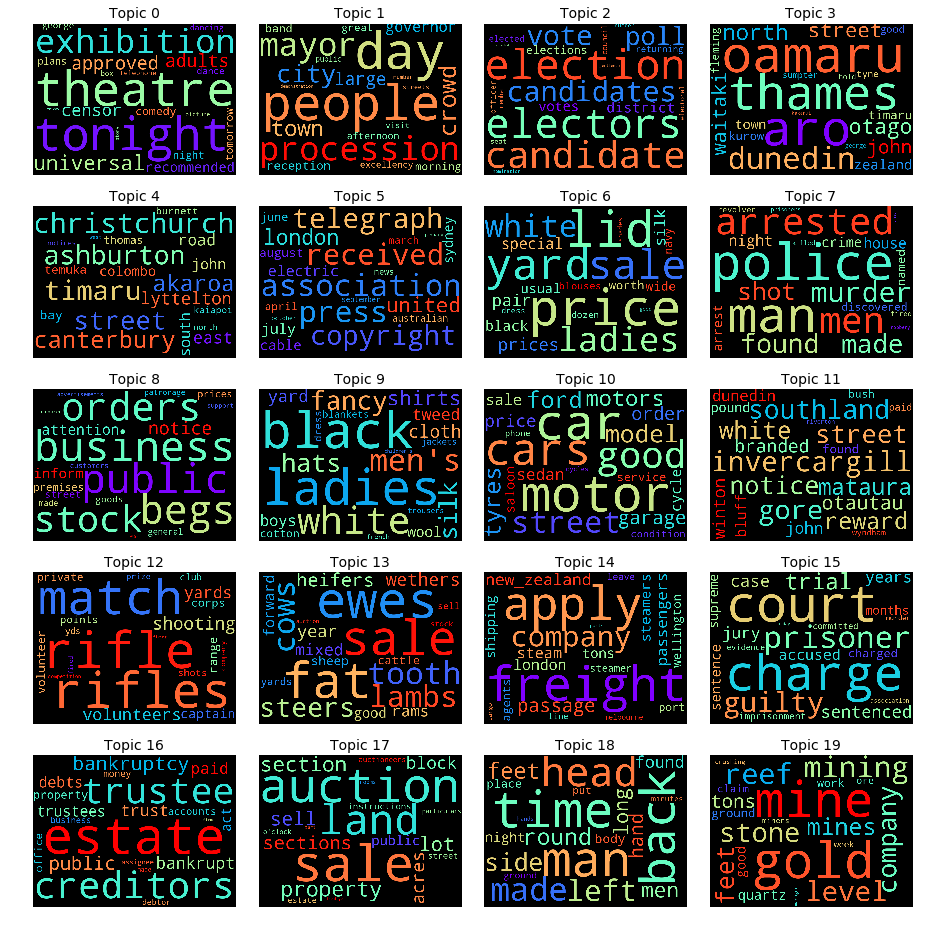

In [12]:
#show_num_topics = df_plt.shape[0]
plt_topics = 20
plt_words  = 20
plt_cols   = 4

cloud = WordCloud(width=800,
                  height=600,
                  max_words=plt_words,
                  colormap='rainbow')

fig, axes = plt.subplots(int(plt_topics/4), plt_cols,
                         figsize=(13,13), 
                         sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(df_plt.iloc[i]['cloudwords'],
                                    max_font_size=200)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic {}'.format(i), fontdict=dict(size=14))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 3.2 Documents Distribution

**Before checking the topic distribution, we should take a look at the documents distribution.**

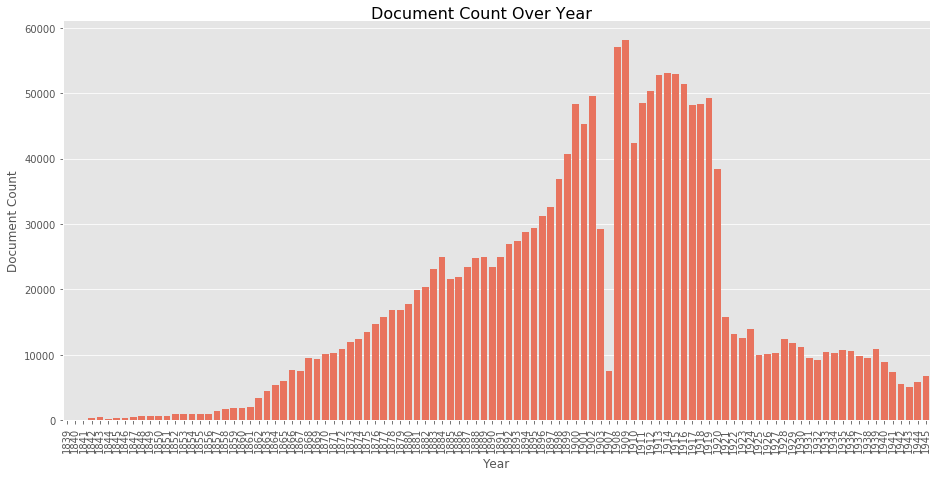

In [13]:
g = sns.catplot(x="year", color='tomato',
                kind='count', height=6.5, aspect=2, 
                dodge=False, legend=False, 
                data=df_domtopic)
g.fig.suptitle("Document Count Over Year", fontsize=16)
g.fig.subplots_adjust(top=0.95)
g.set(xlabel='Year', ylabel='Document Count')        
g.set_xticklabels(rotation=90, step=1)

### 3.3 Dominant Topics Distribution

**We plot all the dominant topics to glimpse the distribution in general.**

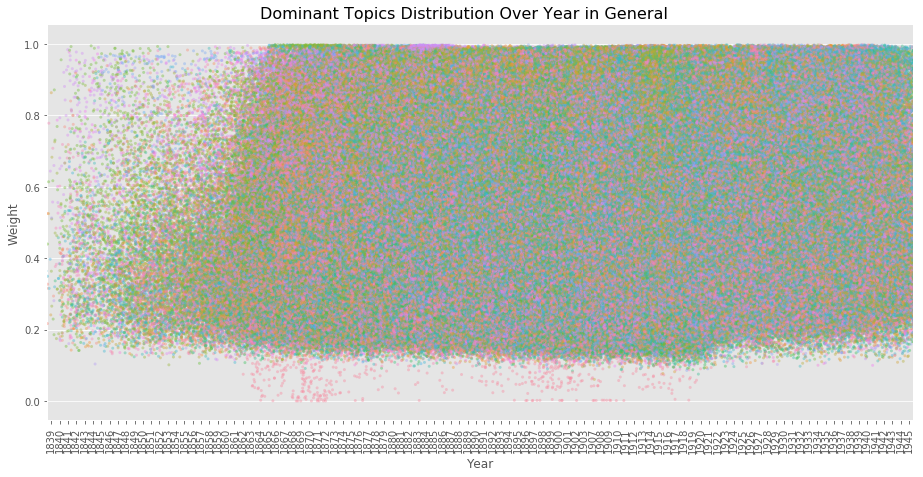

In [14]:
g = sns.catplot(x="year", y='weight', hue='topic',
                kind='strip', height=6.5, aspect=2, 
                jitter=2, dodge=False, 
                s=3, alpha=0.4, edgecolors='w',
                legend=False,
                data=df_domtopic)

g.fig.subplots_adjust(top=0.94)
g.fig.suptitle("Dominant Topics Distribution Over Year in General", fontsize=16)
g.set(xlabel='Year', ylabel='Weight')
g.set_xticklabels(rotation=90)

### 3.4 Average Weight of Each Topic

**Plot all topics average weight to check trend of each topic.**

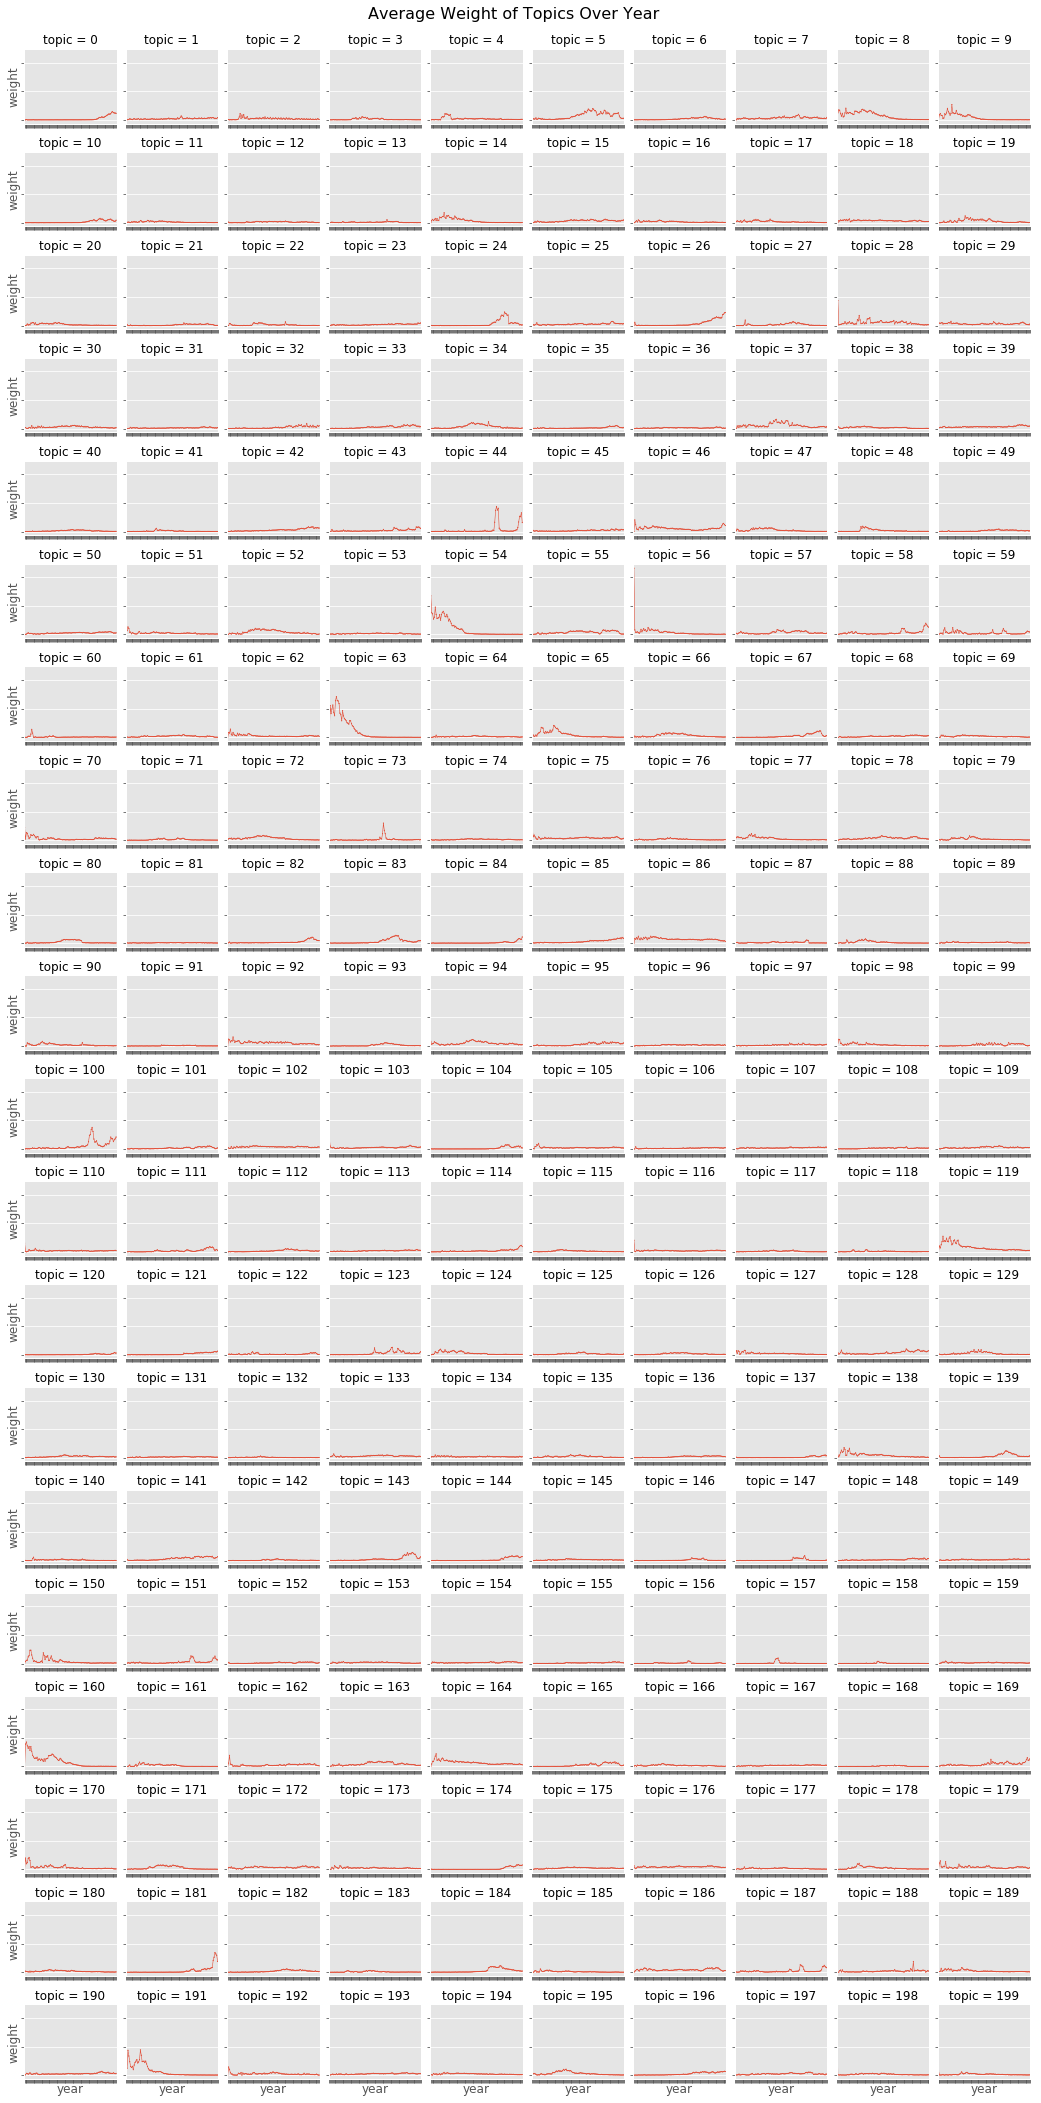

In [15]:
g = sns.catplot(x="year", y='weight',  col='topic', col_wrap=10, 
                kind='point', height=1.5, aspect=1, dodge=False, s=0.2, legend=False, 
                markers='.', scale=0.2,
                data=df_avgweight)
g.fig.suptitle("Average Weight of Topics Over Year", fontsize=16)
g.set_xticklabels(visible=False)
g.set_yticklabels(visible=False)
g.fig.subplots_adjust(top=0.96, hspace=0.4, wspace=0.1)

## 4 The First 10 Topics

**Before we try to find topics with specific features, we plot the first 10 topics to see the situation:**

**Generate dominant topics dataframe for plot:**

In [16]:
topic_list = list(range(10))

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Shape of df_plt_dom: (97652, 6)
Shape of df_plt_avg: (1040, 4)


weight  \
topic            
0      0.00194   
1      0.00774   
2      0.00689   
3      0.00764   
4      0.00998   
5      0.03908   
6      0.00676   
7      0.01094   
8      0.01595   
9      0.00375   

                                                                                                                      keywords  
topic                                                                                                                           
0      theatre tonight exhibition universal approved adults censor recommended comedy tomorrow night plans dance george dan...  
1      day people procession mayor city crowd town large governor reception band morning great afternoon excellency visit p...  
2      election electors candidate candidates vote poll district votes elections returning elected officer council seat ele...  
3      oamaru aro thames dunedin north otago street waitaki john zealand town timaru kurow fleming good tyne sumpter hold g...  
4      christchurch timaru ashburton street canterbury akaroa lyttelton east road south john colombo bay temuka thomas burn...  
5      association press received telegraph copyright london united electric july cable sydney august june april march aust...  
6       price lid yard sale ladies white prices pair silk special black usual wide worth navy blouses dozen dress shades good   
7      police man arrested men murder found made shot night house crime arrest named discovered revolver fired killed priso...  
8      business public begs orders stock notice attention inform premises street prices goods general made patronage custom...  
9      black ladies white men's fancy hats silk shirts cloth yard tweed boys wool cotton dress blankets jackets trousers fr...

**Dominant topics distribution over year:**

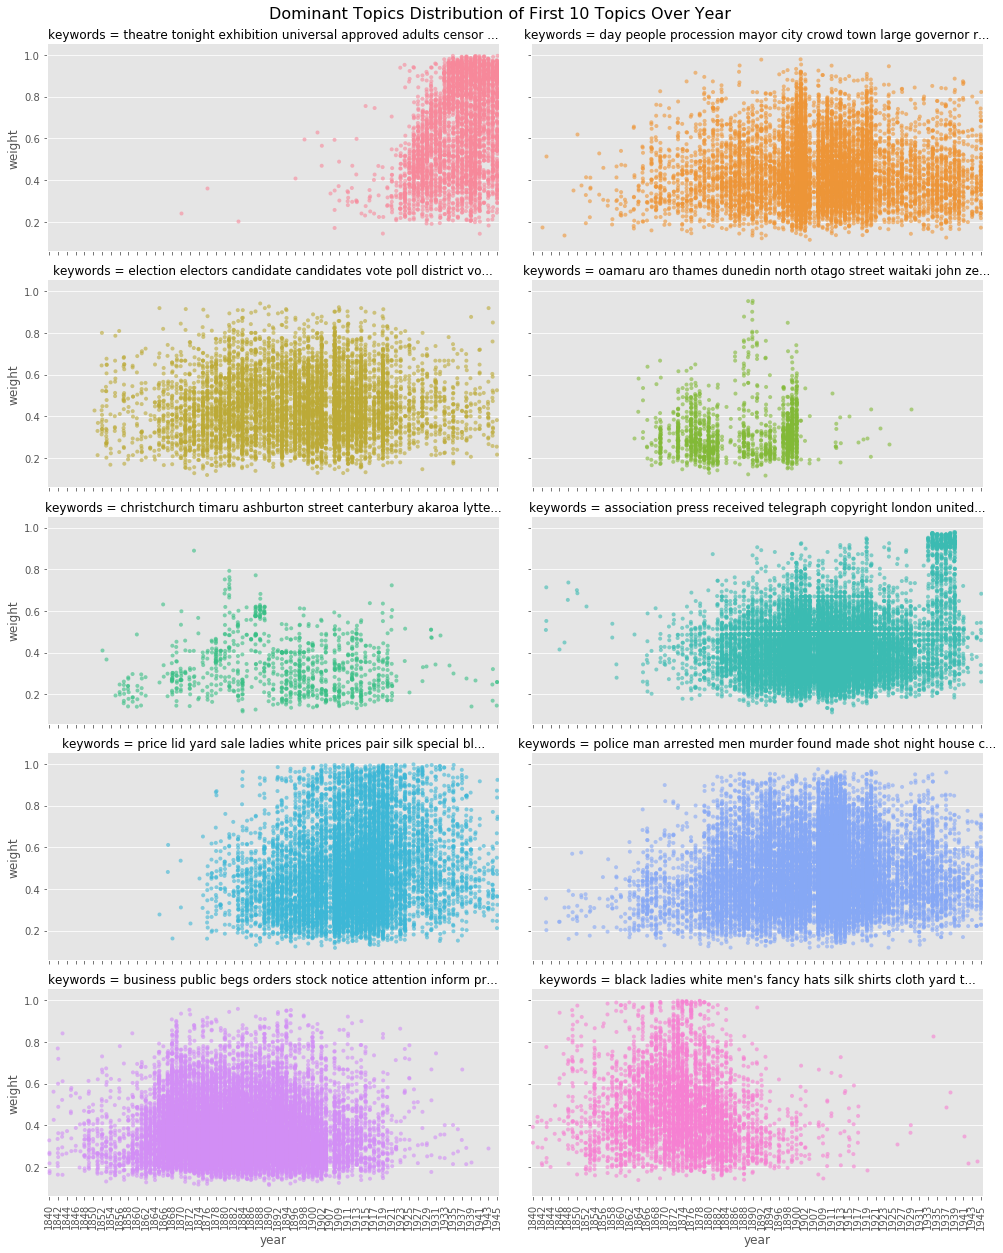

In [17]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Dominant topics count over year:**

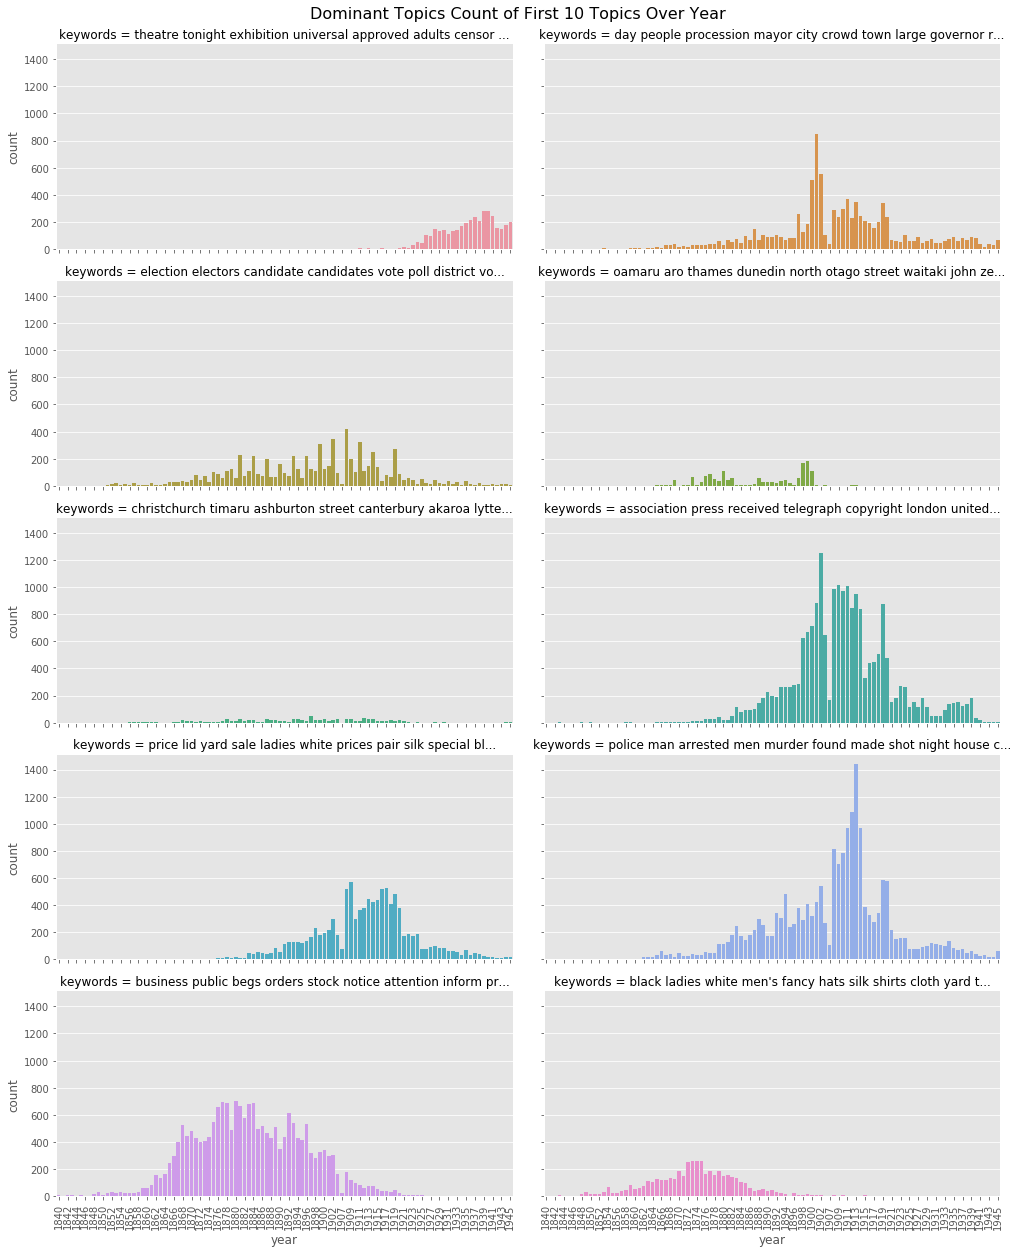

In [18]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Average topic weight over year:**

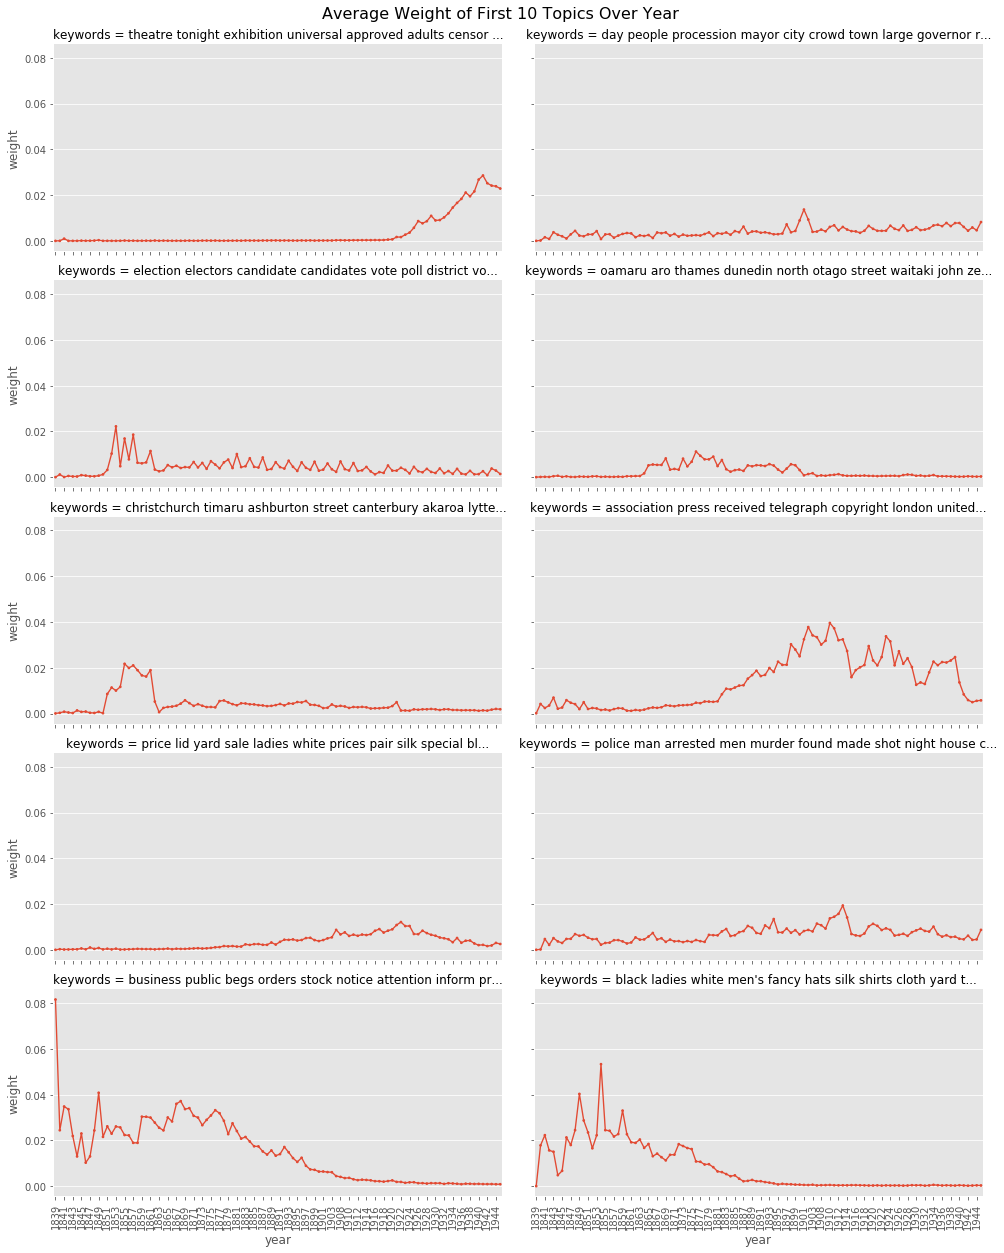

In [19]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

## 5 The Most Variant Topics

**By caculating the standard deviation of average weight of each topic, we get the most variant topics. Some weights of topic may vary following the overall trends, it's better to remove the effect of overall trend for more accurate evaluation. Here we ignore the effect of overall trends.**

In [20]:
topic_list = list(df_avgweight.groupby('topic')['weight']
                  .std().sort_values(ascending=False).index[:10])

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [63, 54, 56, 191, 160, 44, 100, 198, 8, 181]
Shape of df_plt_dom: (139732, 6)
Shape of df_plt_avg: (1040, 4)


weight  \
topic            
63     0.00457   
54     0.00659   
56     0.00601   
191    0.00593   
160    0.00613   
44     0.00778   
100    0.01416   
198    0.00623   
8      0.01595   
181    0.00492   

                                                                                                                      keywords  
topic                                                                                                                           
63           cases case casks boxes ditto sale bags oil brandy sugar ale tea tons tobacco bales candles flour kegs white hhds   
54     government provincial colony province council general superintendent new_zealand public colonial governor time prese...  
56     iron wire forks american tools lamps knives patent nails table lead ironmongery stoves large brass galvanised oil si...  
191    sale apply land house acres particulars property terms good town street situated lease section cottage hotel section...  
160    tons schooner arrived port cargo barque passengers melbourne sailed wellington lyttelton ship london agents auckland...  
44     enemy german germans front french london british fighting troops attack received captured russian artillery line sta...  
100    german germany received war london peace berlin government russia states paris france russian french allies correspo...  
198    iron machinery engines machines steam machine patent made ploughs engine agents steel work horse harrows double plou...  
8      business public begs orders stock notice attention inform premises street prices goods general made patronage custom...  
181    air london flying flight aeroplane miles british wireless machine aircraft bombs aeroplanes raid machines german pla...

**Dominant topics distribution over year:**

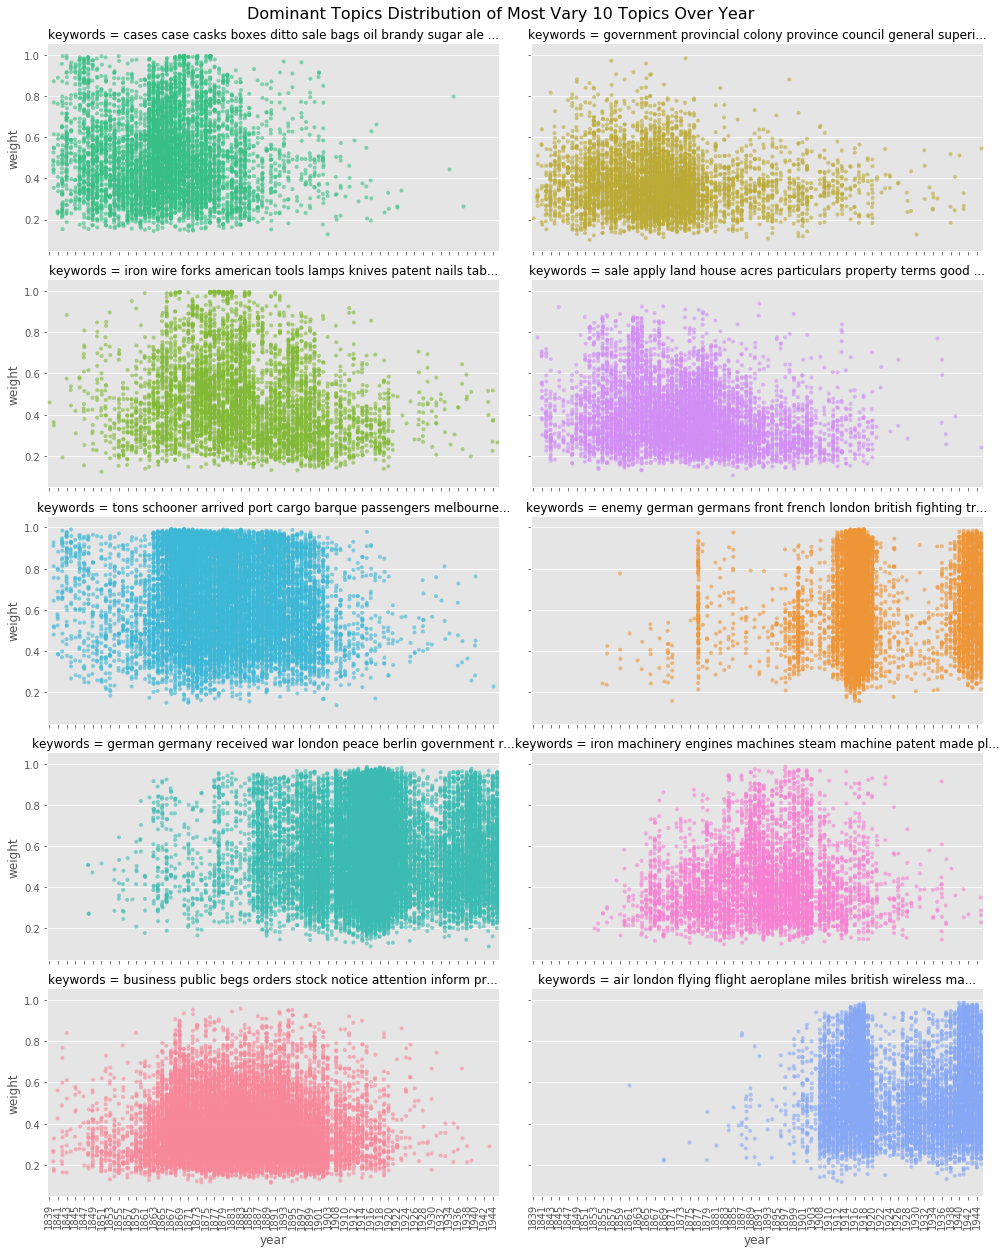

In [21]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Vary 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Dominant topics count over year:**

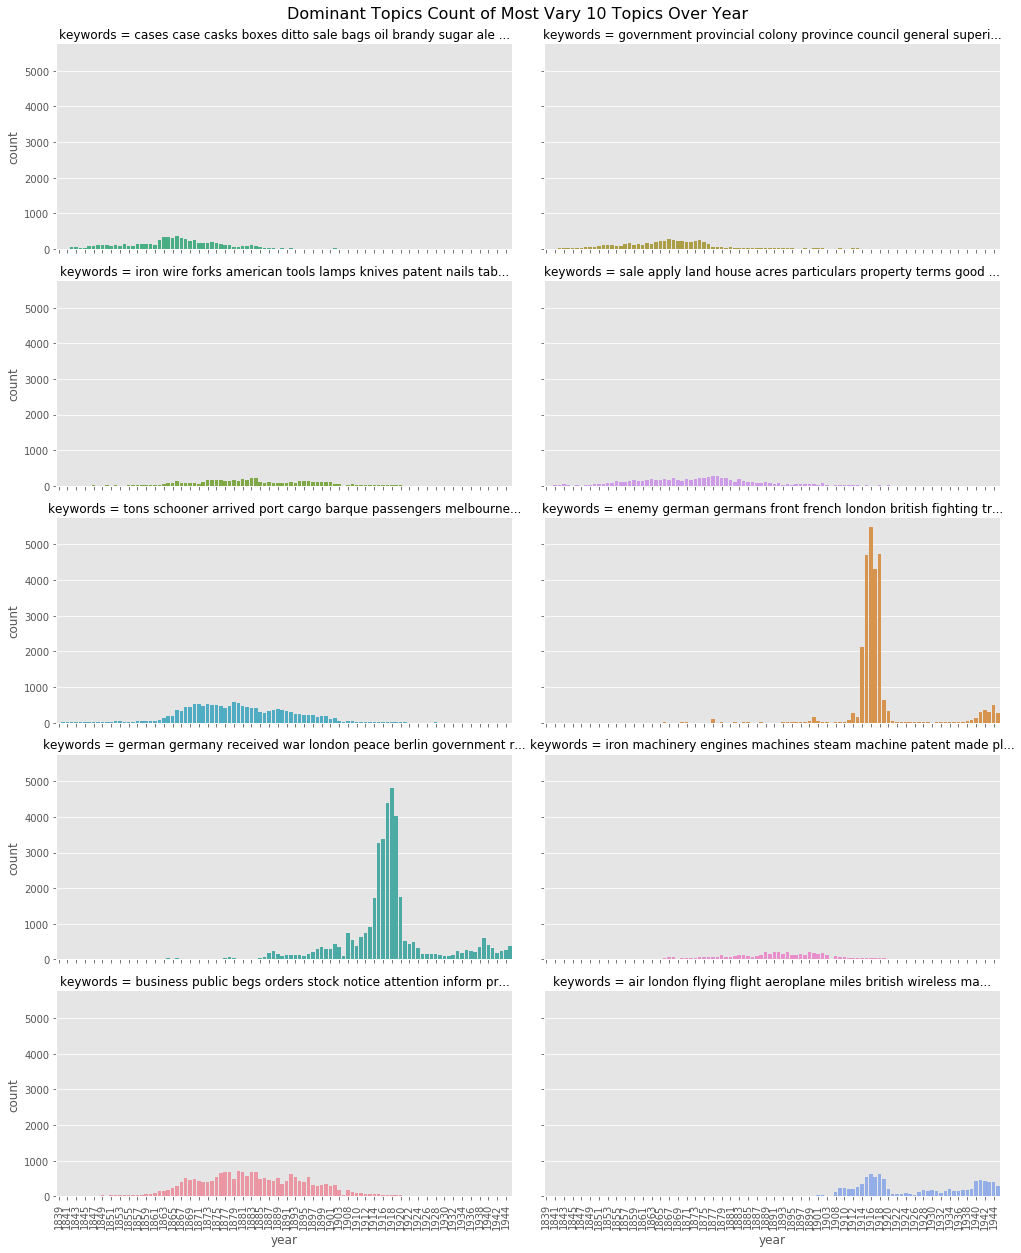

In [22]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Vary 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Average topic weight over year:**

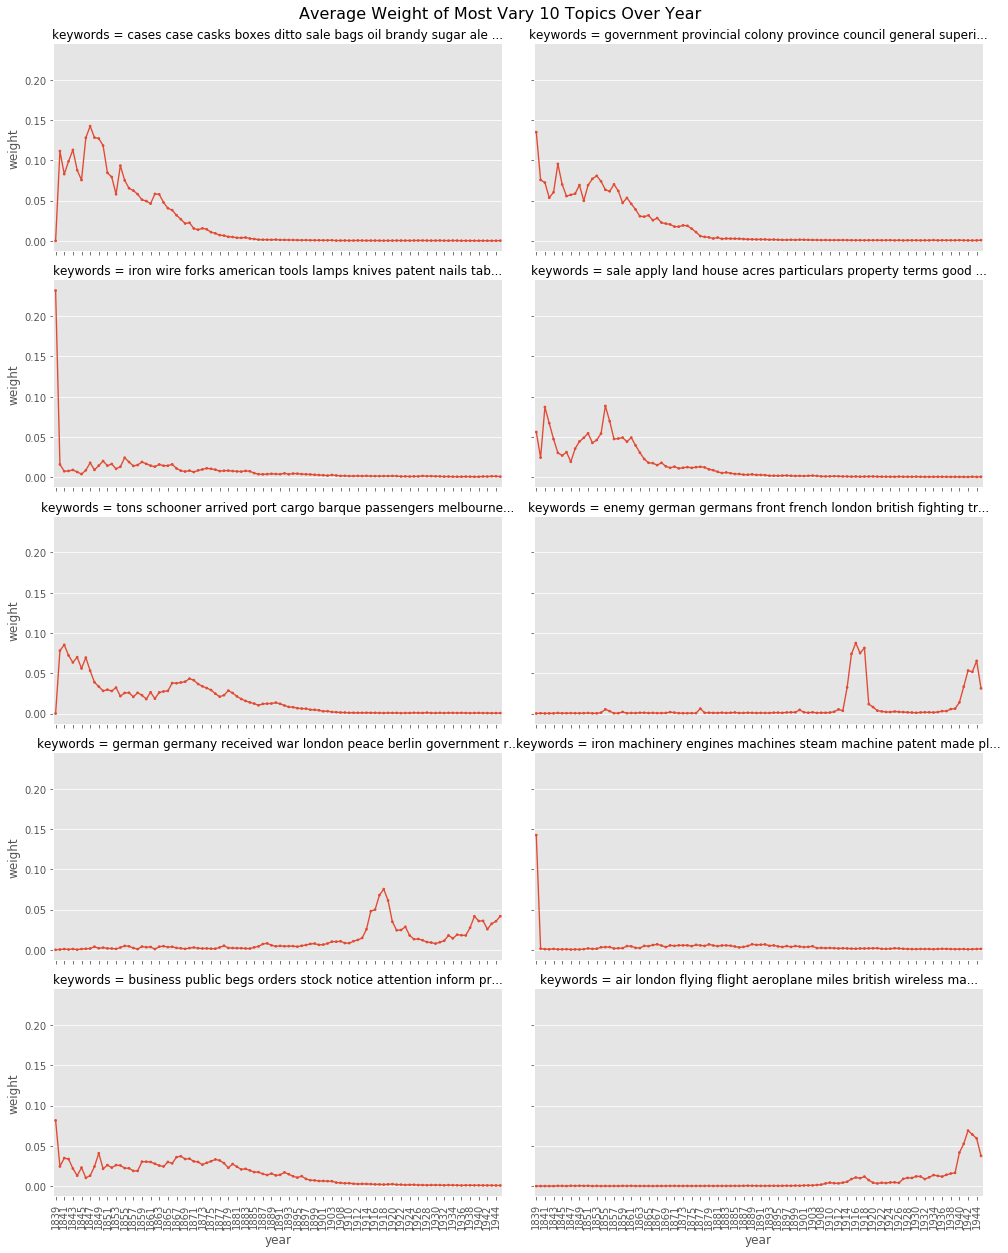

In [23]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Vary 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

## 6 The Most Significant Topics

**Variance dose not consider the document number, if a topic has high variance but the support documents are few, the topic is not significant. To find significant, we use the figure that dominant topic count multiply the average weight of the topic, this figure considers both the number of support document and the average weight of topic. This way magnifies the topics that are dominant topics of documents, we take it as significant topics.**

In [24]:
df_domtopic_count = (df_domtopic.groupby(['year', 'topic'])
                     .size().reset_index(name='count')
                     .sort_values(['year', 'topic']))
df_domtopic_count.columns = ['year_', 'topic_', 'count']

df_signif = df_avgweight.copy(deep=True)

df_signif = (df_signif
             .merge(df_domtopic_count, left_on=['year', 'topic'], right_on=['year_', 'topic_'], how='outer')
             .sort_values(by=['year', 'topic'])
             .drop(columns=['keywords', 'year_', 'topic_'])
             .reset_index(drop=True)
             .fillna(0))

df_signif['value'] = df_signif['weight'] * df_signif['count']

topic_list = list(df_signif.groupby('topic')['value'].std().sort_values(ascending=False).index[:10])

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [44, 100, 73, 83, 5, 37, 184, 24, 123, 151]
Shape of df_plt_dom: (225095, 6)
Shape of df_plt_avg: (1040, 4)


weight  \
topic            
44     0.00778   
100    0.01416   
73     0.00612   
83     0.01066   
5      0.03908   
37     0.01247   
184    0.01289   
24     0.00628   
123    0.00858   
151    0.00807   

                                                                                                                      keywords  
topic                                                                                                                           
44     enemy german germans front french london british fighting troops attack received captured russian artillery line sta...  
100    german germany received war london peace berlin government russia states paris france russian french allies correspo...  
73     south africa boers british general war transvaal boer lord london african cape received capetown contingent pretoria...  
83     cough column colds advertisements cure cold remedy coughs advt bottle throat nazol woods great lung peppermint baxte...  
5      association press received telegraph copyright london united electric july cable sydney august june april march aust...  
37     french government british london paris troops received foreign france russian russia general news turkish india cons...  
184    prices advertisements column street suit good quality made latest make price suits call phone give ladies wear buy o...  
24     theatre picture pictures story programme to-night drama film comedy star love shown great life girl feature night su...  
123    strike union men miners work coal workers labour dispute association federation employers arbitration conference wag...  
151    ships naval british navy fleet german vessels sea submarine ship admiral london tons admiralty war sunk received sub...

**Dominant topics distribution over year:**

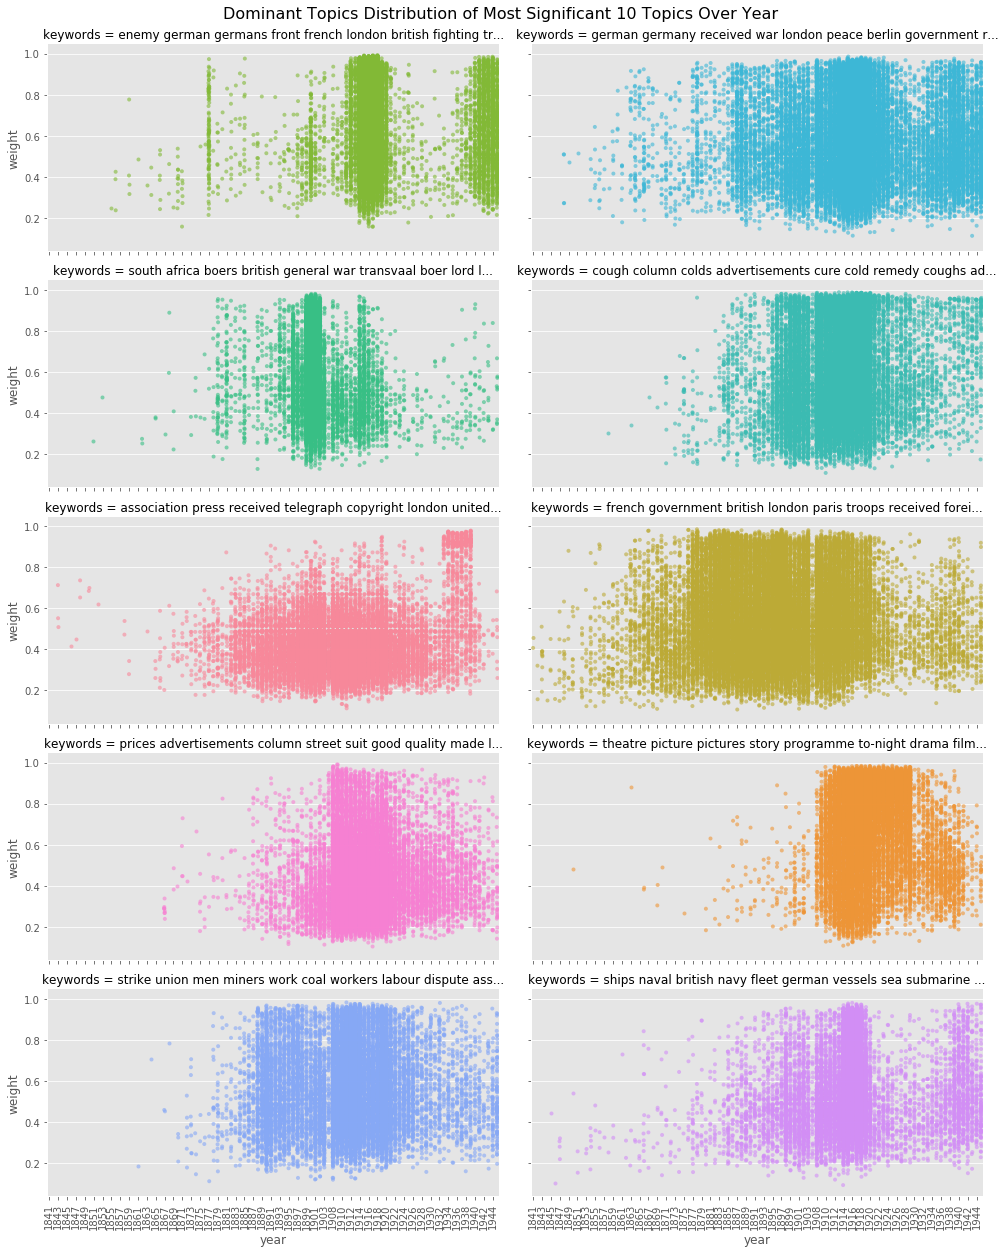

In [25]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Dominant topics count over year:**

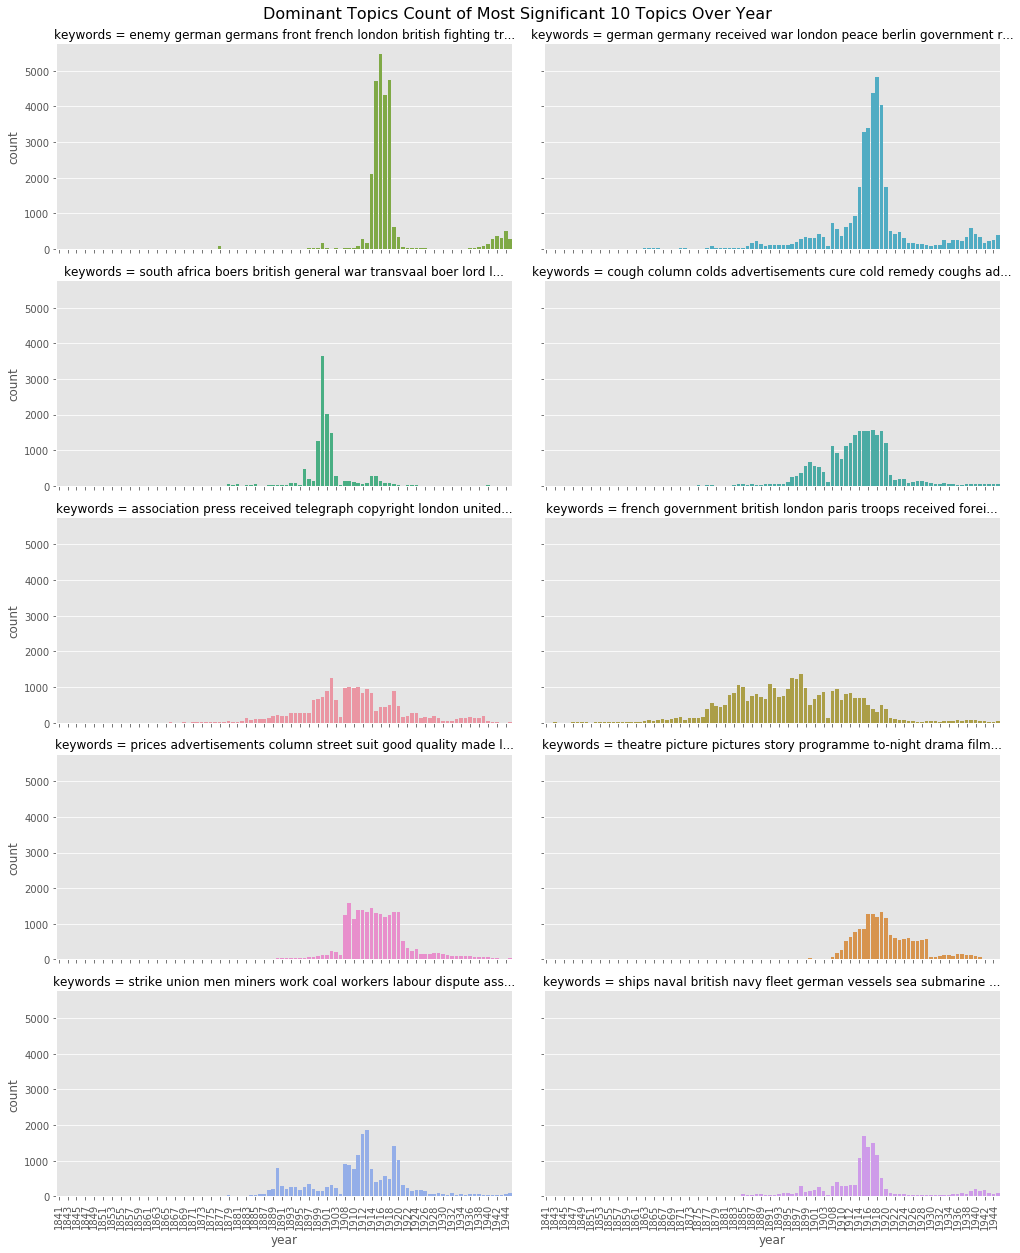

In [26]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Average topic weight over year:**

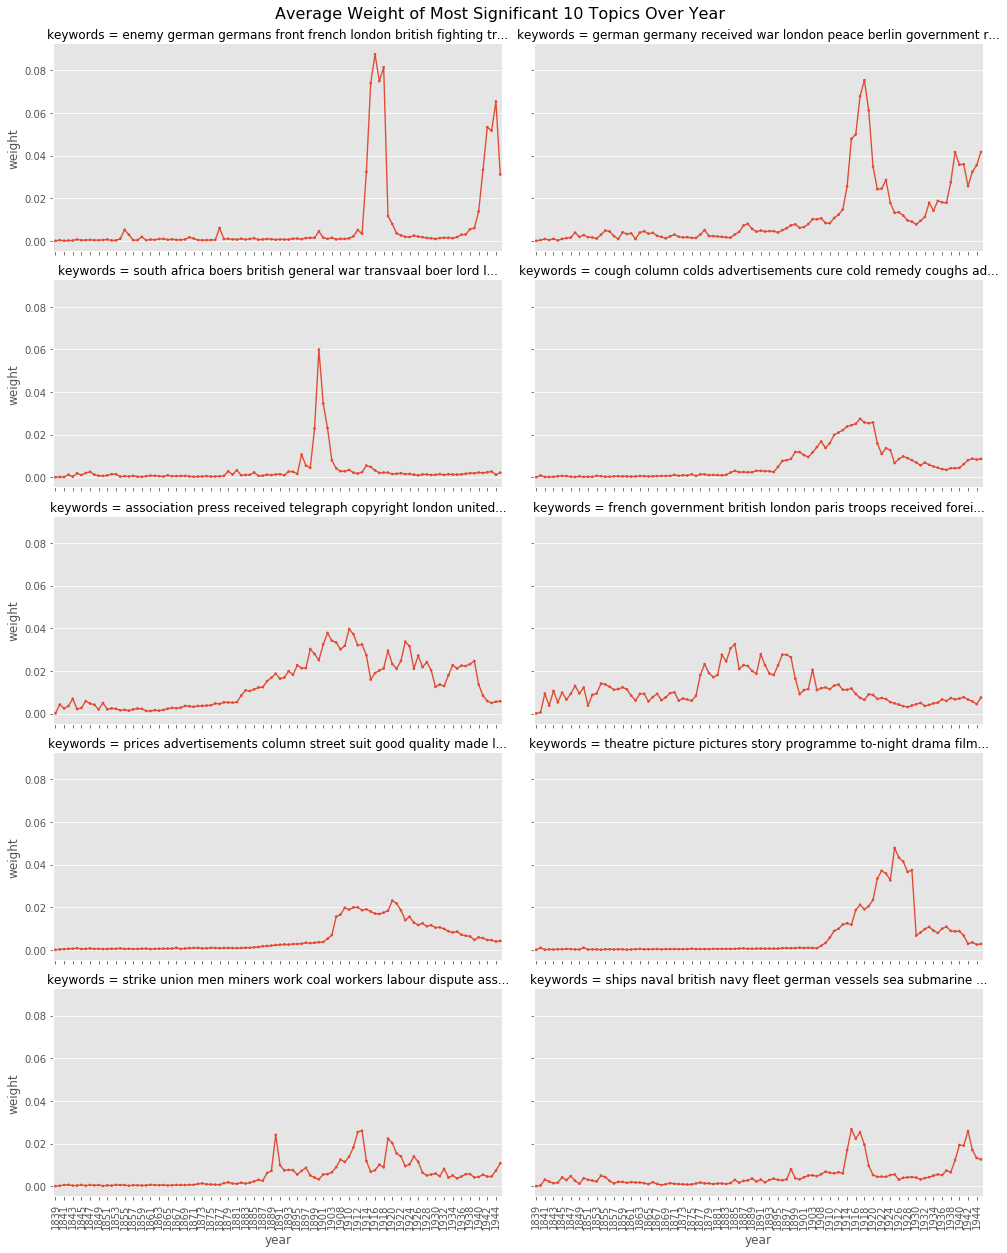

In [27]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

---

In [28]:
gc.collect()

230